<a href="https://colab.research.google.com/github/tonyychen/Projects/blob/master/Other%20Side%20Projects/Global_Temperature_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Data Source https://climate.nasa.gov/vital-signs/global-temperature/

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
filepath = '/drive/My Drive/Data/Global_Temperature_by_year.txt'

In [5]:
#Data Preprocessing

In [6]:
with open(filepath, 'r') as file:
  data = file.read()

In [7]:
data = data.split('\n')
print(data[:10])
print(data[-10:])

['Land-Ocean Temperature Index (C)', '--------------------------------', '', 'Year No_Smoothing  Lowess(5)', '----------------------------', '1880     -0.15     -0.08', '1881     -0.07     -0.11', '1882     -0.09     -0.15', '1883     -0.16     -0.19', '1884     -0.27     -0.22']
['2011      0.61      0.67', '2012      0.65      0.70', '2013      0.68      0.74', '2014      0.75      0.79', '2015      0.90      0.83', '2016      1.02      0.87', '2017      0.93      0.92', '2018      0.86      0.95', '2019      0.99      0.99', '']


In [8]:
data = data[5:-1]

In [9]:
years = []
temperatures = []
for row in data:
  split = row.split('     ')
  years.append(split[0])
  temperatures.append(split[1])

In [10]:
years = np.asarray(years, dtype = np.int32)
temperatures = np.asarray(temperatures, dtype = np.float32)

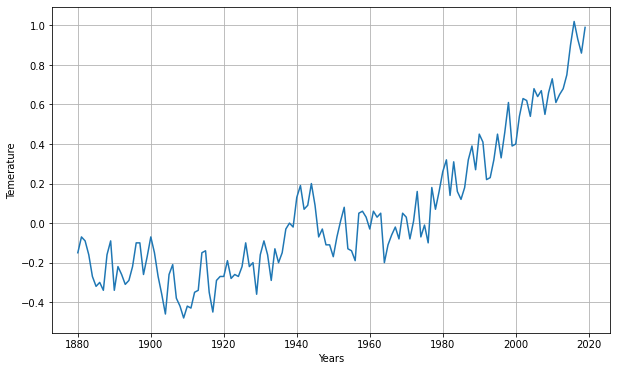

In [11]:
#Visualization
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.plot(years, temperatures)
plt.xlabel('Years')
plt.ylabel('Temerature')
plt.grid()
plt.show()

We can see the global warming effect from the plot

In [12]:
#Data Preparation

In [13]:
ds = tf.data.Dataset.from_tensor_slices(temperatures)

In [14]:
#1. build sequence dimension
window_size = 9
ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
ds = ds.flat_map(lambda row_ds: row_ds.batch(window_size + 1))

In [15]:
#2. Split the data into Xs and Ys
ds = ds.map(lambda x: (tf.expand_dims(x[:window_size], axis = -1), x[-1]))

In [16]:
for i in ds.take(1):
  print(i)

(<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[-0.15],
       [-0.07],
       [-0.09],
       [-0.16],
       [-0.27],
       [-0.32],
       [-0.3 ],
       [-0.34],
       [-0.16]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.09>)


In [17]:
#3. Split into training and validation sets
num_examples = len(temperatures) - window_size
print('num examples:', num_examples)

#We take validation set first, because we would like to train on the latest data (with abnormal temperatures)
ds_val = ds.take(20)
ds_train = ds.skip(20)

num examples: 131


In [18]:
#4. Shuffle and Batch
ds_train = ds_train.shuffle(200).batch(20).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(20).cache()

In [19]:
#Now we can build the model

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters = 50, kernel_size = 3, padding = 'causal', input_shape = (None, 1)))
model.add(tf.keras.layers.LSTM(30, return_sequences = True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)))
model.add(tf.keras.layers.Dense(10, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 50)          200       
_________________________________________________________________
lstm (LSTM)                  (None, None, 30)          9720      
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 13,421
Trainable params: 13,421
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mse'])

In [22]:
#build callback
#callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [23]:
#Fit the model
num_epochs = 100

history = model.fit(ds_train, epochs = num_epochs, validation_data = ds_val, verbose = 0)

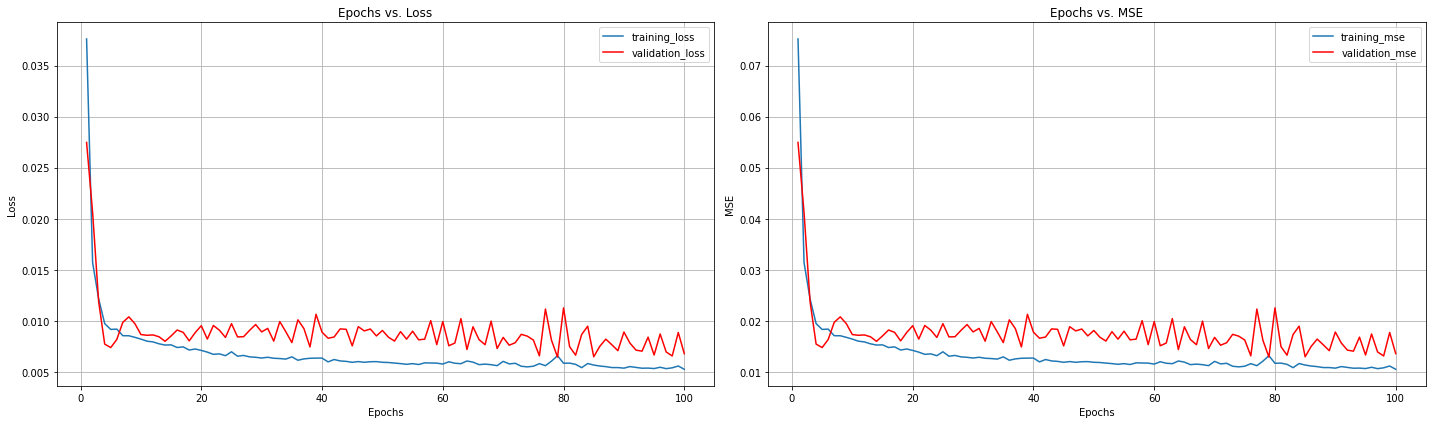

In [24]:
#Let's plot losses and mses
epochs = np.arange(num_epochs) + 1

fig = plt.figure(figsize = (20, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epochs, history.history['loss'], label = 'training_loss')
ax.plot(epochs, history.history['val_loss'], 'r', label = 'validation_loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Epochs vs. Loss')
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(epochs, history.history['mse'], label = 'training_mse')
ax.plot(epochs, history.history['val_mse'], 'r', label = 'validation_mse')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.set_title('Epochs vs. MSE')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

In [25]:
#As we can see, the loss does not really improve after 10 epochs, maybe we can try to gradually decrease the learning rate and see if we can get a little bit better results
callback = tf.keras.callbacks.LearningRateScheduler(lambda x: (num_epochs - x)/num_epochs * 0.001)

In [26]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters = 50, kernel_size = 3, padding = 'causal', input_shape = (None, 1)))
model.add(tf.keras.layers.LSTM(30, return_sequences = True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)))
model.add(tf.keras.layers.Dense(10, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mse'])

history = model.fit(ds_train, epochs = num_epochs, validation_data = ds_val, callbacks = [callback], verbose = 0)

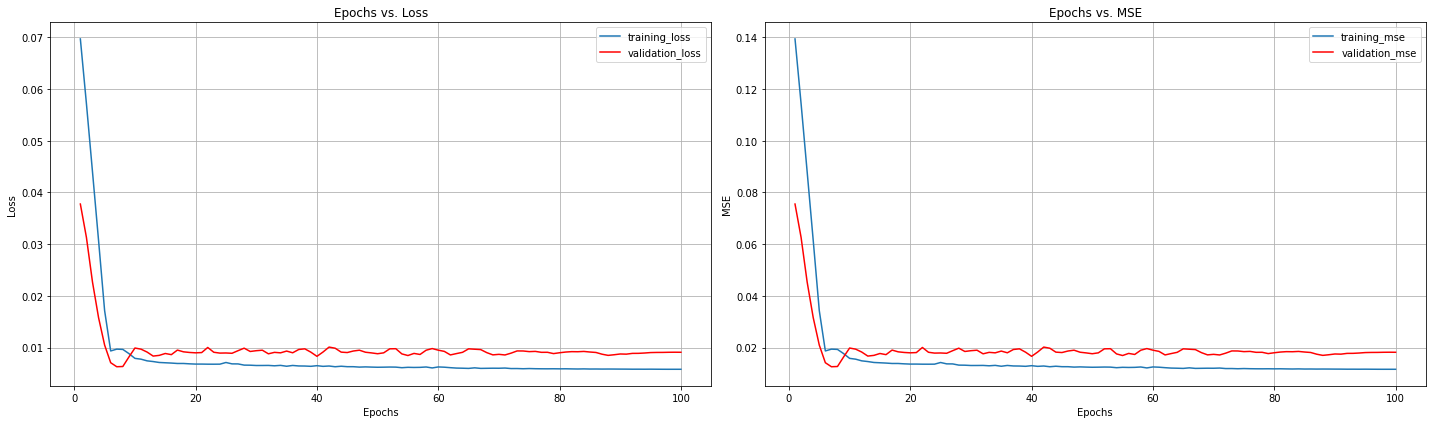

In [27]:
#Let's plot losses and mses
epochs = np.arange(num_epochs) + 1

fig = plt.figure(figsize = (20, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epochs, history.history['loss'], label = 'training_loss')
ax.plot(epochs, history.history['val_loss'], 'r', label = 'validation_loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Epochs vs. Loss')
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(epochs, history.history['mse'], label = 'training_mse')
ax.plot(epochs, history.history['val_mse'], 'r', label = 'validation_mse')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.set_title('Epochs vs. MSE')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

In [28]:
#We got almost the same plots as before but our plots are smoother this time, and that is a good thing

In [29]:
#Finally, let's make predictions on the validation dataset and plot the actual vs. predicted temperatures
preds = model.predict(ds_val).ravel()
actual = np.array([])
for i in ds_val:
  actual = np.append(actual, i[1].numpy())

In [30]:
years_val = np.arange(years.min() + window_size + 1, years.min() + window_size + 1 + 20)

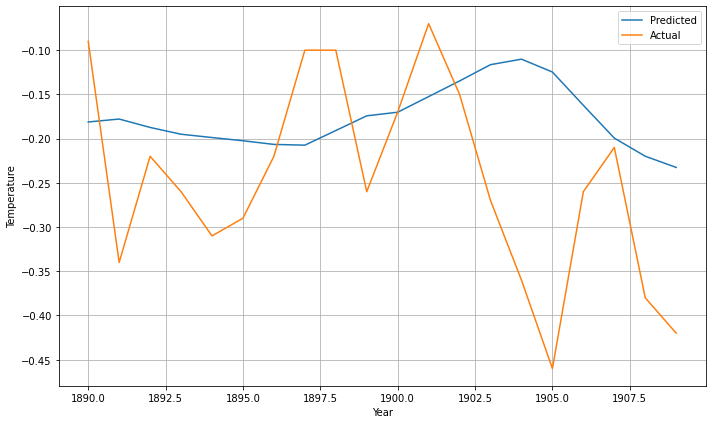

In [32]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(years_val, preds, label = 'Predicted')
ax.plot(years_val, actual, label = 'Actual')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

In [33]:
#It seems that we did not get a good result, let's also try to predict for the entire time range including both train and validation

In [34]:
ds_all = ds.batch(1)
preds = model.predict(ds_all).ravel()
actual = temperatures[9:]

In [35]:
years_all = years[9:]

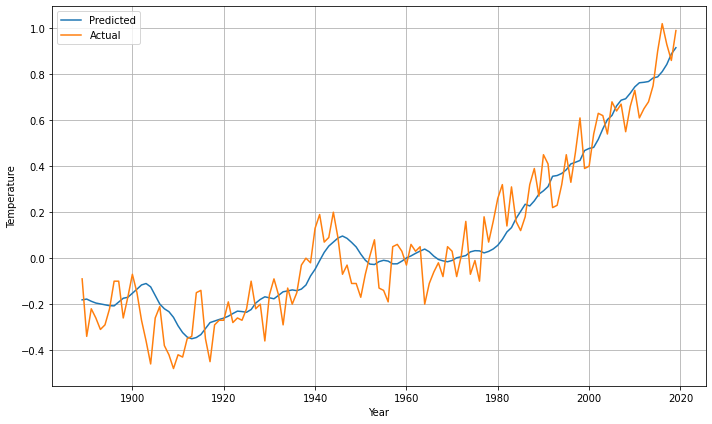

In [36]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(years_all, preds, label = 'Predicted')
ax.plot(years_all, actual, label = 'Actual')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

In [37]:
#Overall, we seem to be doing okay